d:\Capstone\El Nino\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Capstone\El Nino\venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Capstone\El Nino\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Capstone\El Nino\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Capstone\El Nino\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fi

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 25, number of used features: 0
[LightGBM] [Info] Start training from score 0.376311
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

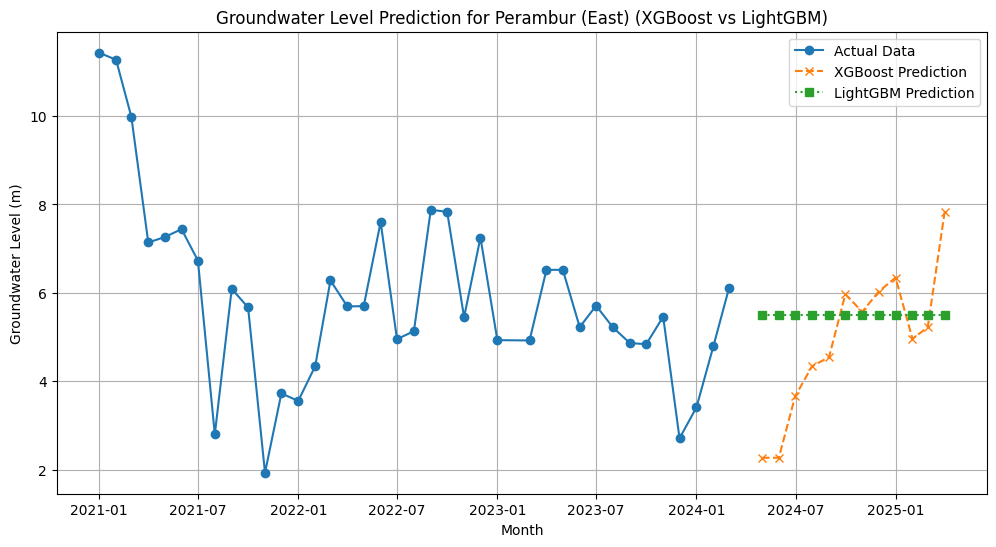

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# File paths for 2021-2024 datasets
file_paths = {
    2021: "../dataset/chennai-ground-water-levels-2021.csv",
    2022: "../dataset/chennai-ground-water-levels-2022.csv",
    2023: "../dataset/chennai-ground-water-levels-2023.csv",
    2024: "../dataset/chennai-ground-water-levels-2024.csv"
}

# Load all datasets into a single DataFrame
df_list = []
for year, path in file_paths.items():
    df = pd.read_csv(path)
    df["Year"] = year  # Add Year column
    df_list.append(df)

df_all_years = pd.concat(df_list)

# Fix month column names by stripping spaces
df_all_years.rename(columns=lambda x: x.strip(), inplace=True)

# Updated month list without spaces
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Convert to numeric
df_all_years[months] = df_all_years[months].apply(pd.to_numeric, errors='coerce')

# Select a specific location for forecasting (e.g., Perambur (East))
location = "Perambur (East)"
df_location = df_all_years[df_all_years["Location"] == location][["Year"] + months]

# Reshape into time series format
df_location = df_location.set_index("Year").stack().reset_index()
df_location.columns = ["Year", "Month", "Groundwater Level"]

# Strip extra spaces from Month column values
df_location["Month"] = df_location["Month"].str.strip()

# Convert to datetime
df_location["Date"] = pd.to_datetime(df_location["Year"].astype(str) + "-" + df_location["Month"], format="%Y-%b", errors="coerce")

# Drop any NaN values and set Date as index
df_location = df_location[["Date", "Groundwater Level"]].dropna()
df_location.set_index("Date", inplace=True)

# Normalize Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_location)

# Prepare Data for XGBoost/LightGBM
sequence_length = 6  # Using last 6 months to predict the next month
X, y = [], []
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i + sequence_length].flatten())
    y.append(data_scaled[i + sequence_length])

X, y = np.array(X), np.array(y)

# Split into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Train LightGBM model
lgb_model = lgb.LGBMRegressor(objective="regression", n_estimators=100, learning_rate=0.1)
lgb_model.fit(X_train, y_train)

# Predict on test set
xgb_preds = xgb_model.predict(X_test)
lgb_preds = lgb_model.predict(X_test)

# Compute RMSE
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_preds))

print(f"XGBoost RMSE: {xgb_rmse:.4f}")
print(f"LightGBM RMSE: {lgb_rmse:.4f}")

# Predict Next 12 Months
future_predictions_xgb, future_predictions_lgb = [], []
input_seq = X[-1].reshape(1, -1)

for _ in range(12):  # Predict next 12 months
    next_value_xgb = xgb_model.predict(input_seq)[0]
    next_value_lgb = lgb_model.predict(input_seq)[0]
    
    future_predictions_xgb.append(next_value_xgb)
    future_predictions_lgb.append(next_value_lgb)
    
    input_seq = np.append(input_seq[:, 1:], [[next_value_xgb]], axis=1)  # Slide window

# Convert back to original scale
future_predictions_xgb = scaler.inverse_transform(np.array(future_predictions_xgb).reshape(-1, 1))
future_predictions_lgb = scaler.inverse_transform(np.array(future_predictions_lgb).reshape(-1, 1))

# Generate future dates
future_dates = pd.date_range(start=df_location.index[-1] + pd.DateOffset(months=1), periods=12, freq="M")

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(df_location.index, df_location["Groundwater Level"], marker='o', label="Actual Data")
plt.plot(future_dates, future_predictions_xgb, marker='x', linestyle="dashed", label="XGBoost Prediction")
plt.plot(future_dates, future_predictions_lgb, marker='s', linestyle="dotted", label="LightGBM Prediction")
plt.xlabel("Month")
plt.ylabel("Groundwater Level (m)")
plt.title(f"Groundwater Level Prediction for {location} (XGBoost vs LightGBM)")
plt.legend()
plt.grid()
plt.show()
